#Bibliotecas



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


# Função para converter valores monetários

In [2]:
def converter_valor(valor):
    try:
        if pd.isna(valor):
            return 0.0
        valor_str = str(valor).strip()
        #Remove caracteres não numéricos exceto vírgula e ponto
        valor_limpo = ''.join(c for c in valor_str if c.isdigit() or c in [',', '.', '-'])

        if not valor_limpo:
            return 0.0

        #Trata diferentes formatos de decimais
        if ',' in valor_limpo and '.' in valor_limpo:
            valor_limpo = valor_limpo.replace('.', '').replace(',', '.')
        elif ',' in valor_limpo:
            valor_limpo = valor_limpo.replace(',', '.')

        return float(valor_limpo)
    except:
        return 0.0

#Função para formatação monetária

In [3]:
def format_currency(x, pos):
    if x >= 1e9:
        return f'R$ {x/1e9:,.1f} Bi'
    elif x >= 1e6:
        return f'R$ {x/1e6:,.1f} Mi'
    elif x >= 1e3:
        return f'R$ {x/1e3:,.0f} mil'
    else:
        return f'R$ {x:,.0f}'

# Carregar o arquivo

In [4]:
file_path = "gasto_covid_dados_abertos.csv"
df = pd.read_csv(file_path, sep=None, engine="python", encoding="latin1")

#Informaçoes

In [5]:
#Tratamento Básico dos Dados
print(f"Total de registros: {len(df):,}")
print("\nValores ausentes antes:")
print(df.isna().sum())

Total de registros: 9,813

Valores ausentes antes:
numero_empenho             0
data_empenho            2149
orgao                   1903
numero_contrato         2932
valor_empenho           1903
credor                  2149
modalidade_licitacao    2724
item                    1903
natureza                2239
fund_legal              2853
num_certidao            4011
data_termino            3189
numero_processo         4177
local_execucao          2239
processo_licitacao      4011
integra_contrato        2422
situacao_entrega        2239
url_dispensa            8181
exercicio               2575
acao                    2580
fonte                   2575
cod_fonte               2575
subfonte                2575
cod_acao                2575
elemento                2575
modalidade_aplicacao    2575
dtype: int64


#Tratamento dos dados

In [7]:
# Dicionário de preenchimento para valores ausentes
fill_values = {
    'numero_contrato': "CONTRATO NÃO INFORMADO",
    'modalidade_licitacao': "NÃO SE APLICA",
    'fund_legal': "FUNDAMENTO NÃO INFORMADO",
    'numero_processo': "NÃO INFORMADO",
    'local_execucao': "LOCAL NÃO ESPECIFICADO",
    'integra_contrato': "INTEGRAÇÃO NÃO DISPONÍVEL",
    'situacao_entrega': "NÃO INFORMADO",
    'url_dispensa': "NÃO INFORMADO",
    'acao': "NÃO INFORMADO",
    'fonte': "NÃO INFORMADO",
    'modalidade_aplicacao': "NÃO INFORMADO",
    'orgao': "NÃO INFORMADO",
    'credor': "NÃO INFORMADO",
    'natureza': "NÃO INFORMADO",
    'item': "NÃO INFORMADO"
}

for col, value in fill_values.items():
    if col in df.columns:
        df[col] = df[col].fillna(value).str.upper().str.strip()

# Colunas numéricas
num_cols = ['exercicio', 'cod_fonte', 'subfonte', 'cod_acao']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Conversão de valores monetários
if 'valor_empenho' in df.columns:
    df['valor_empenho'] = df['valor_empenho'].apply(converter_valor)

    # Remover valores negativos
    df = df[df['valor_empenho'] >= 0]

    print("\nEstatísticas de valor_empenho após tratamento:")
    print(df['valor_empenho'].describe().apply(lambda x: format_currency(x, None) if x > 0 else x))

# Tratamento de datas
date_cols = ['data_empenho', 'data_termino']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# Criar colunas temporais
if 'data_empenho' in df.columns:
    df['ano'] = df['data_empenho'].dt.year
    df['mes'] = df['data_empenho'].dt.month_name()
    df['mes_num'] = df['data_empenho'].dt.month
    df['dia'] = df['data_empenho'].dt.day
    df['semana'] = df['data_empenho'].dt.isocalendar().week

# Criar flags para dados ausentes
df['sem_data_empenho'] = df['data_empenho'].isna()
df['sem_data_termino'] = df['data_termino'].isna()

# Remover colunas não utilizadas
cols_to_drop = ['num_certidao', 'processo_licitacao', 'elemento']
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors='ignore')

# Pós-análise
print("\n=== PÓS-ANÁLISE ===")
print(f"Total de registros válidos: {len(df):,}")
print("\nValores ausentes após tratamento:")
print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False))


Estatísticas de valor_empenho após tratamento:
count      R$ 9 mil
mean     R$ 147 mil
std       R$ 1.7 Mi
min             0.0
25%          R$ 110
50%        R$ 6 mil
75%       R$ 41 mil
max      R$ 97.0 Mi
Name: valor_empenho, dtype: object

=== PÓS-ANÁLISE ===
Total de registros válidos: 9,287

Valores ausentes após tratamento:
data_termino    3363
data_empenho    2239
ano             2239
mes             2239
mes_num         2239
dia             2239
semana          2239
dtype: int64


#Distribuição dos valores

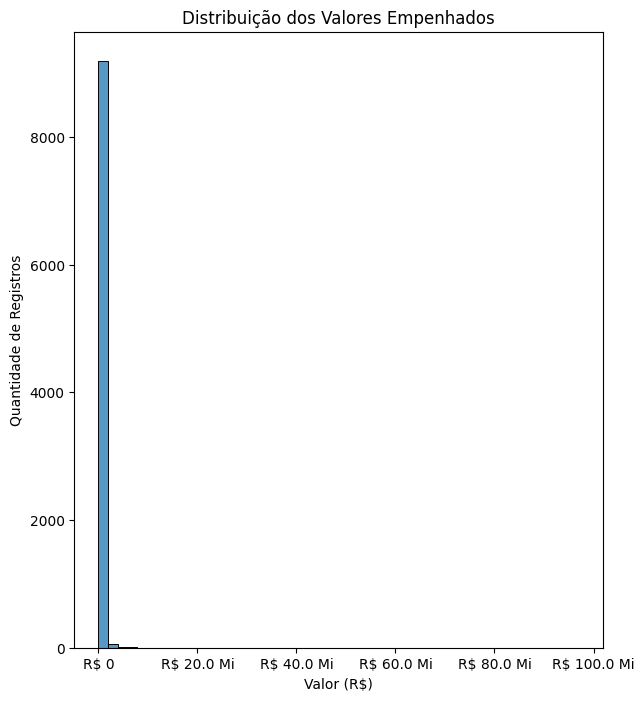

In [8]:
#Visualização dos dados
if 'valor_empenho' in df.columns:
    plt.figure(figsize=(15, 8))


    plt.subplot(1, 2, 1)
    sns.histplot(df['valor_empenho'], bins=50, kde=False)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency))
    plt.title("Distribuição dos Valores Empenhados")
    plt.xlabel("Valor (R$)")
    plt.ylabel("Quantidade de Registros")

#Total de gastos por ano

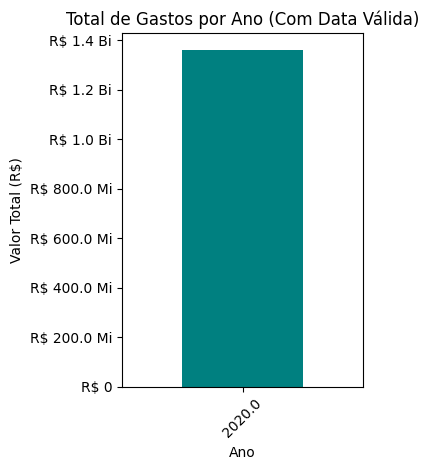

In [9]:
if 'ano' in df.columns:
    plt.subplot(1, 2, 2)
    df_validos = df.dropna(subset=['data_empenho'])
    df_validos.groupby('ano')['valor_empenho'].sum().plot(kind='bar', color='teal')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))
    plt.title("Total de Gastos por Ano (Com Data Válida)")
    plt.xlabel("Ano")
    plt.ylabel("Valor Total (R$)")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Evolução dos gastos ao longo do tempo

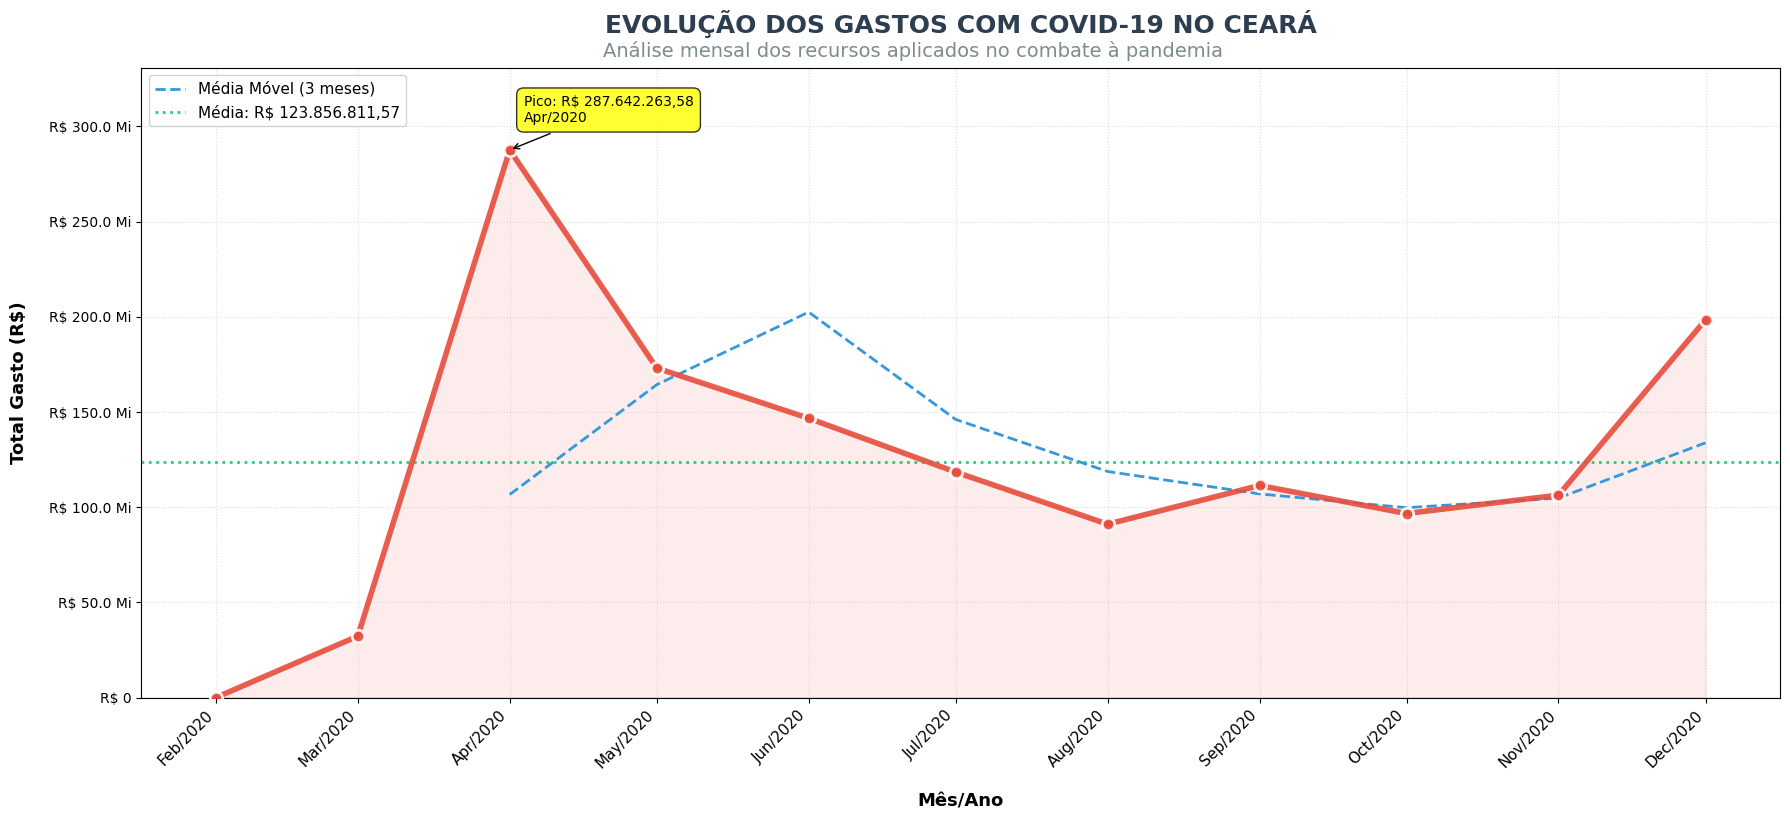

In [15]:
#Criar a série temporal de evolução dos gastos
df_time = df.groupby(df['data_empenho'].dt.to_period("M"))['valor_empenho'].sum()

#Converter e formatar datas
datas = df_time.index.to_timestamp()
datas_formatadas = df_time.index.strftime('%b/%Y')  # Formato MMM/AAAA (ex: Jan/2023)

#Criar gráfico de linha principal
plt.figure(figsize=(18, 9))
linha_principal = plt.plot(datas, df_time.values,
                           marker='o',
                           markersize=9,
                           markerfacecolor='#e74c3c',
                           markeredgecolor='white',
                           markeredgewidth=2,
                           linestyle='-',
                           linewidth=4,
                           color='#e74c3c',
                           alpha=0.9,
                           zorder=5)

#Área preenchida abaixo da curva
plt.fill_between(datas, df_time.values, alpha=0.1, color='#e74c3c')

#Adicionar média móvel (3 meses)
media_movel = df_time.rolling(3).mean()
plt.plot(datas, media_movel.values,
         linestyle='--',
         linewidth=2,
         color='#3498db',
         label='Média Móvel (3 meses)',
         zorder=4)

# Destacar pico máximo
valor_maximo = df_time.max()
data_pico = df_time.idxmax().strftime('%b/%Y')
plt.annotate(f'Pico: R$ {valor_maximo:,.2f}\n{data_pico}'.replace(',', 'X').replace('.', ',').replace('X', '.'),
             xy=(df_time.idxmax().to_timestamp(), valor_maximo),
             xytext=(10, 20),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
             zorder=6)

#Linhas de referência
media_geral = df_time.mean()
plt.axhline(y=media_geral,
            color='#2ecc71',
            linestyle=':',
            linewidth=2,
            label=f'Média: R$ {media_geral:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
plt.axhline(y=0, color='black', linewidth=0.8)

#Configurar eixos
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))
plt.ylabel("Total Gasto (R$)", fontsize=13, labelpad=15, fontweight='bold')
plt.xticks(ticks=datas, labels=datas_formatadas, rotation=45, ha='right', fontsize=11)
plt.xlabel("Mês/Ano", fontsize=13, labelpad=15, fontweight='bold')
plt.grid(True, linestyle=':', alpha=0.4)

#Títulos e legendas
plt.title("EVOLUÇÃO DOS GASTOS COM COVID-19 NO CEARÁ",
         fontsize=18, pad=25, fontweight='bold', color='#2c3e50')
plt.suptitle("Análise mensal dos recursos aplicados no combate à pandemia",
            y=0.88, x=0.51, fontsize=14, color='#7f8c8d')

#Configurar legenda
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)

#Ajustar escala do eixo Y
plt.ylim(0, max(df_time.values) * 1.15)

#Ajustes finais de layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

plt.show()

#Top 10 órgãos que mais gastaram

<ipython-input-16-d9c1087ba88b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_orgaos.values,


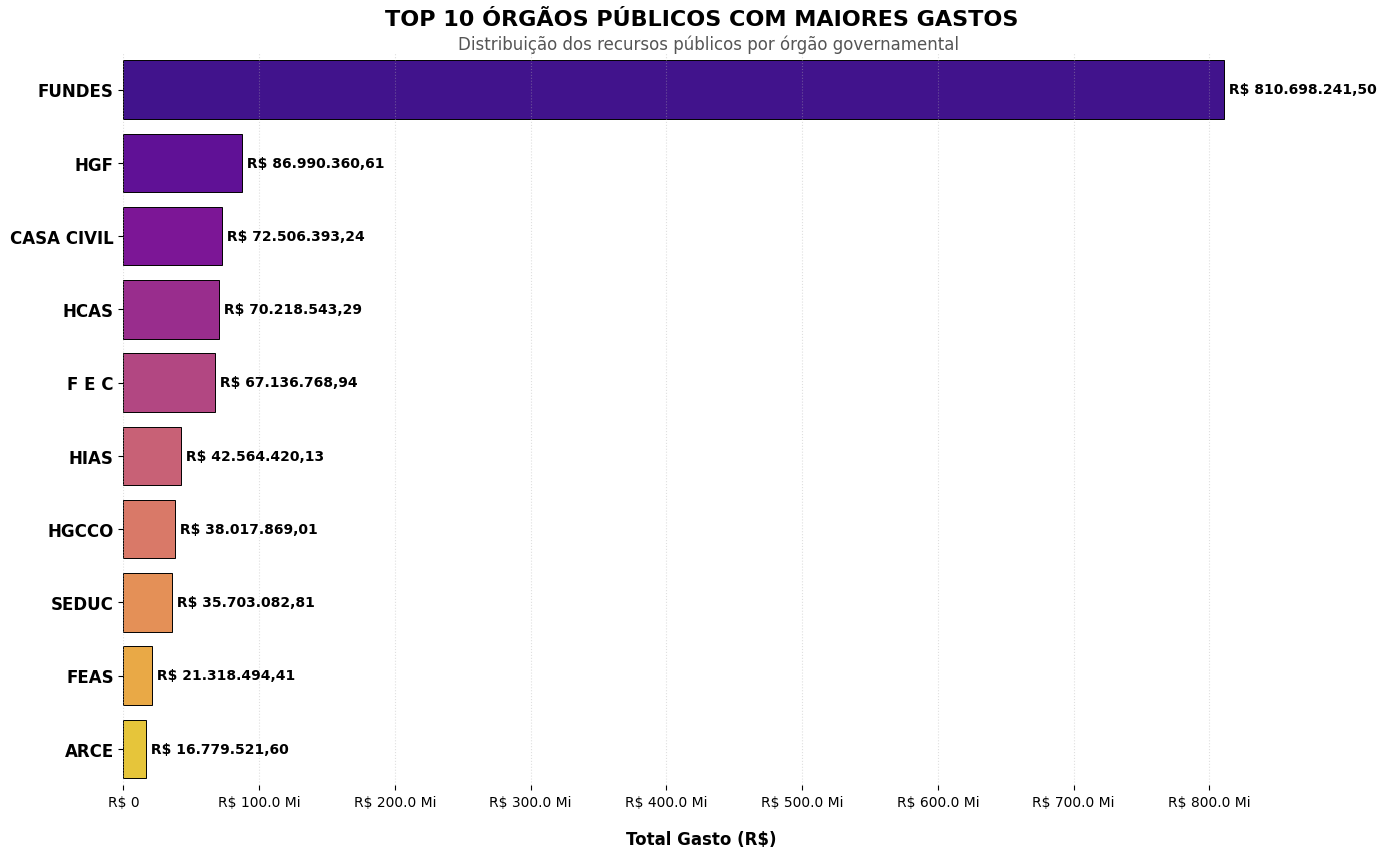

In [16]:
#Calcular o total gasto por órgão (orgao)
top_orgaos = df.groupby('orgao')['valor_empenho'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 9))

#Criar o gráfico de barras horizontais
ax = sns.barplot(x=top_orgaos.values,
                 y=top_orgaos.index,
                 palette="plasma",
                 saturation=0.8,
                 edgecolor='black',
                 linewidth=0.7)

#Adicionar valores formatados nas barras
for i, valor in enumerate(top_orgaos.values):
    valor_formatado = "R$ {:,.2f}".format(valor).replace(",", "X").replace(".", ",").replace("X", ".")
    ax.text(valor,
            i,
            f' {valor_formatado}',
            va='center',
            ha='left',
            fontsize=10,
            fontweight='bold',
            color='black')

#Configuração dos eixos
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.xlabel("Total Gasto (R$)",
           fontsize=12,
           fontweight='bold',
           labelpad=15)
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='semibold')  # Formata nomes dos órgãos

#Elementos visuais
plt.grid(axis='x',
         linestyle=':',
         alpha=0.4)

#Títulos e legendas
plt.title("TOP 10 ÓRGÃOS PÚBLICOS COM MAIORES GASTOS",
          fontsize=16,
          pad=20,
          fontweight='bold')
plt.suptitle("Distribuição dos recursos públicos por órgão governamental",
             y=0.92,
             x=0.51,
             fontsize=12,
             color='#555555')

#Remover bordas
sns.despine(left=True,
            bottom=True)

#Ajustes finais
plt.tight_layout()
plt.subplots_adjust(top=0.9)

#Exibir gráfico
plt.show()

#Top 10 fornecedores por valor recebido


<ipython-input-17-36f03b476de7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_fornecedores.values,
<ipython-input-17-36f03b476de7>:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


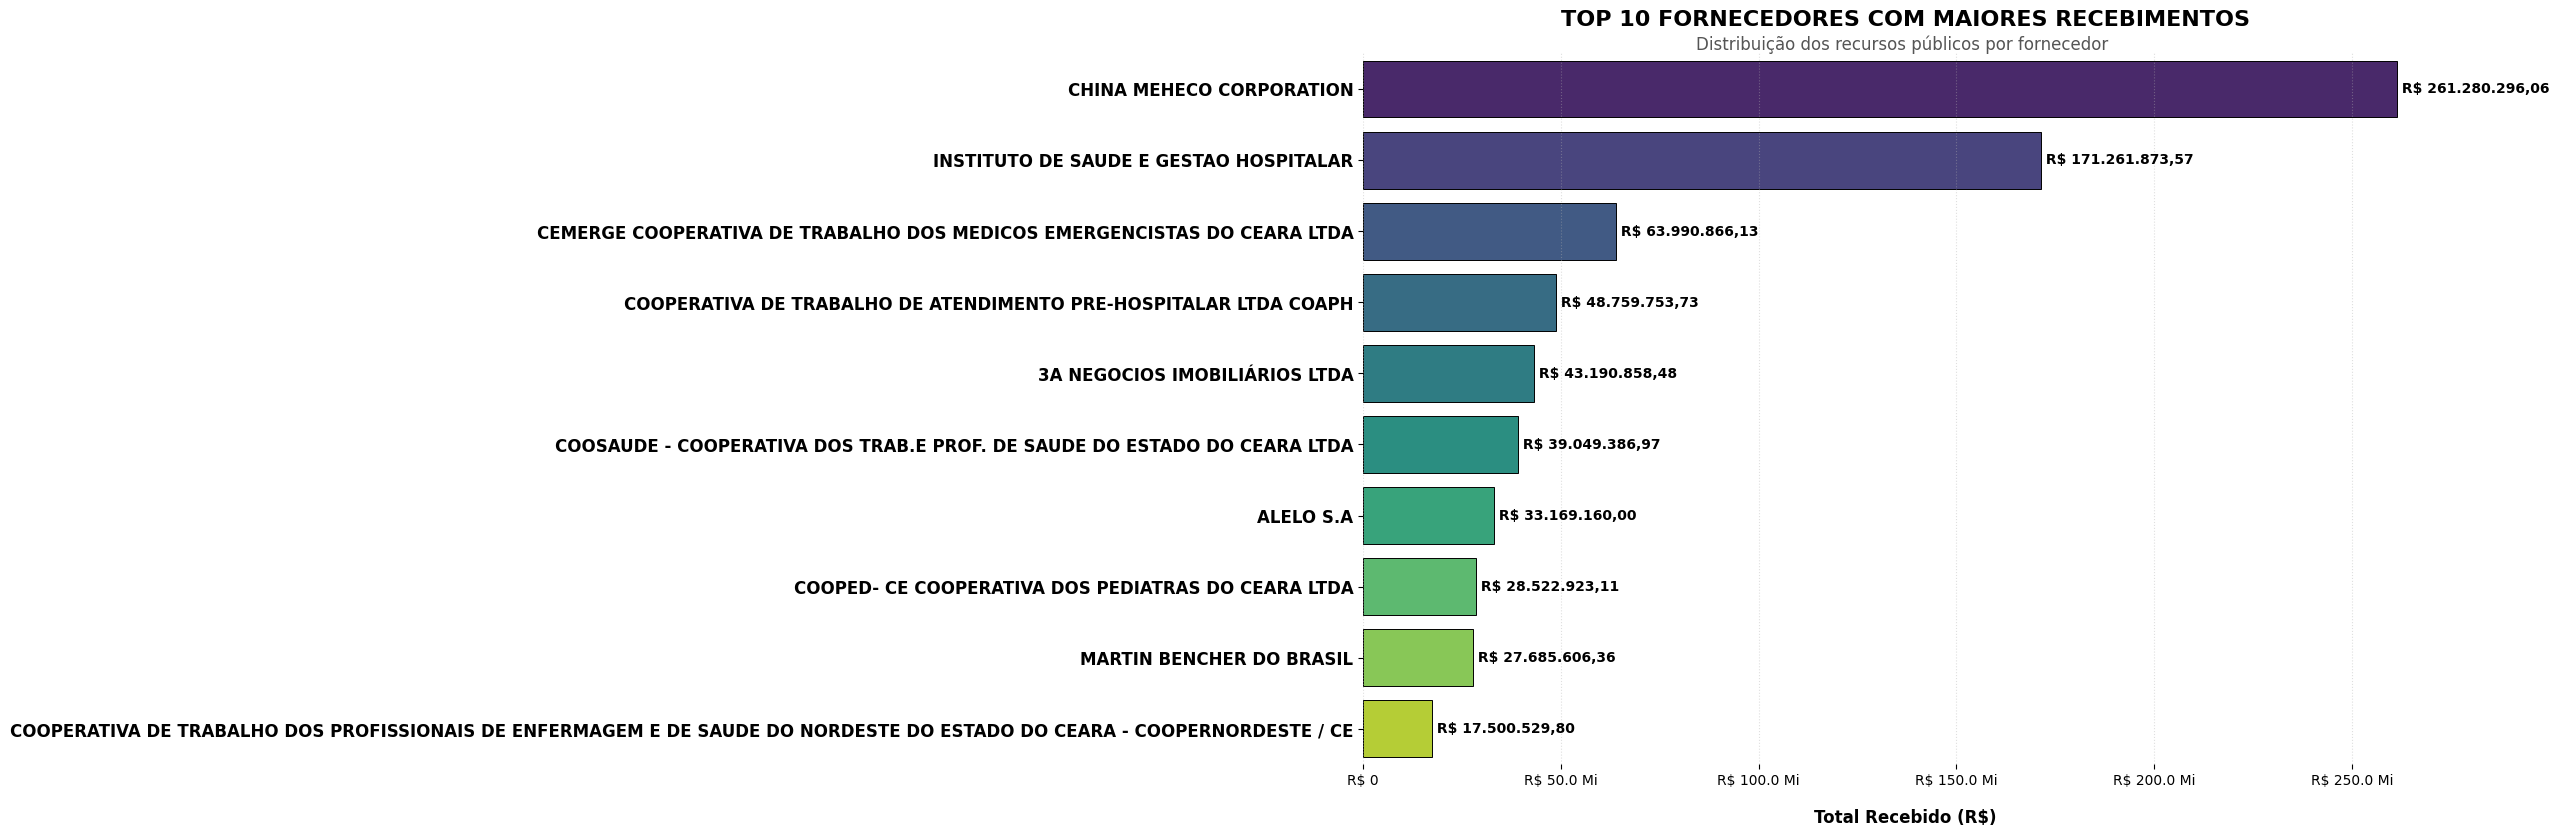

In [17]:
#Calcular o total recebido por fornecedor (credor)
top_fornecedores = df.groupby('credor')['valor_empenho'].sum().sort_values(ascending=False).head(10)

#Criar o gráfico de barras horizontais
plt.figure(figsize=(14, 9))

#Criar o gráfico de barras horizontais
ax = sns.barplot(x=top_fornecedores.values,
                 y=top_fornecedores.index,
                 palette="viridis",
                 saturation=0.8,
                 edgecolor='black',
                 linewidth=0.7)

#Adicionar valores formatados nas barras
for i, valor in enumerate(top_fornecedores.values):
    valor_formatado = "R$ {:,.2f}".format(valor).replace(",", "X").replace(".", ",").replace("X", ".")
    ax.text(valor,
            i,
            f' {valor_formatado}',
            va='center',
            ha='left',
            fontsize=10,
            fontweight='bold',
            color='black')

#Configuração dos eixos
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.xlabel("Total Recebido (R$)",
           fontsize=12,
           fontweight='bold',
           labelpad=15)
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='semibold')  # Formata nomes dos fornecedores

plt.grid(axis='x',
         linestyle=':',
         alpha=0.4)

#Títulos e legendas
plt.title("TOP 10 FORNECEDORES COM MAIORES RECEBIMENTOS",
          fontsize=16,
          pad=20,
          fontweight='bold')
plt.suptitle("Distribuição dos recursos públicos por fornecedor",
             y=0.92,
             x=0.51,
             fontsize=12,
             color='#555555')

#Remover bordas
sns.despine(left=True,
            bottom=True)

#Ajustes finais
plt.tight_layout()
plt.subplots_adjust(top=0.9)

#Exibir gráfico
plt.show()


# Análise de Frequência de Itens

# Top 10 Itens mais adquiridos por valor


<ipython-input-18-24fca21ce75d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_itens.values,


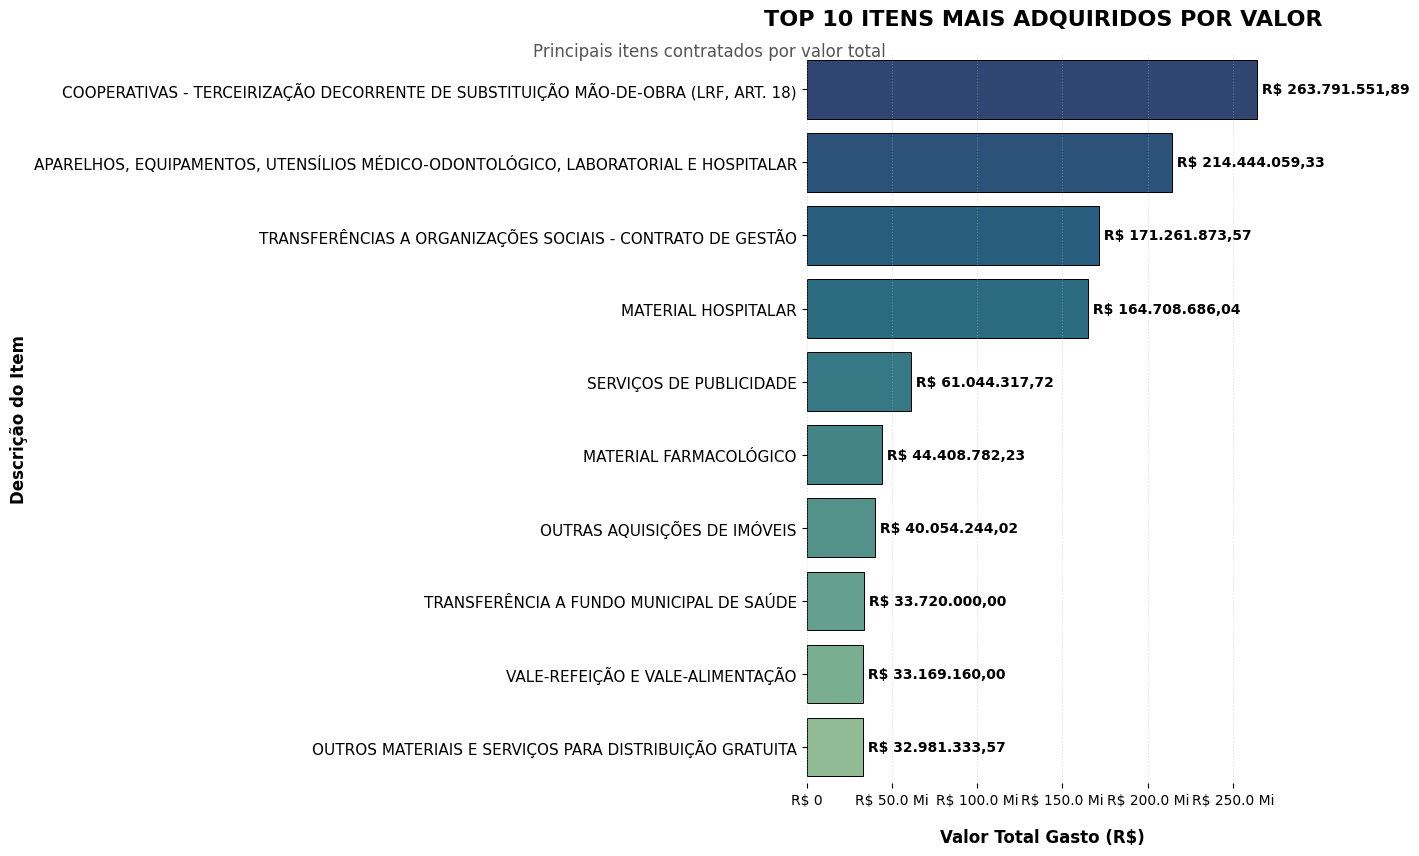

In [18]:
#Preparação dos dados (agora com ordem decrescente correta)
top_itens = df.groupby('item')['valor_empenho'].sum().nlargest(10).sort_values(ascending=False)

#Configuração do gráfico
plt.figure(figsize=(14, 9))
ax = sns.barplot(x=top_itens.values,
                 y=top_itens.index,
                 palette="crest_r",
                 saturation=0.8,
                 edgecolor='black',
                 linewidth=0.7)

#Adicionar valores formatados nas barras
for i, valor in enumerate(top_itens.values):
    valor_formatado = f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    ax.text(valor,
            i,
            f' {valor_formatado}',
            va='center',
            ha='left',
            fontsize=10,
            fontweight='bold',
            color='black')

#Configuração dos eixos
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.xlabel("Valor Total Gasto (R$)", fontsize=12, fontweight='bold', labelpad=15)
plt.ylabel("Descrição do Item", fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

#Títulos e informações
plt.title("TOP 10 ITENS MAIS ADQUIRIDOS POR VALOR",
          fontsize=16, pad=20, fontweight='bold')
plt.suptitle("Principais itens contratados por valor total",
             y=0.91, x=0.51, fontsize=12, color='#555555')

#Elementos visuais
plt.grid(axis='x', linestyle=':', alpha=0.4)
sns.despine(left=True, bottom=True)

#Ajustes finais
plt.tight_layout()
plt.show()